In [2]:
# import data from kaggle 
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

creds = '{"username":"sebasmanco","key":"a0f01aadb0e584b9c9aa0e8ebf5a2696"}'                        # credentials for kaggle APi 
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 23.0MB/s]

In [3]:
# some additonal options
import torch, numpy as np, pandas as pd 

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 200)

# Linear model and neural net from scratch 

In the first place, we have to see what will be the data to analyze, for this we can use the pandas library of python. With it we can import the data (originally in a csv format) to a dataframe that allows us to see and analyze it into python:

In [4]:
df = pd.read_csv(path/'train.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


As we can see, there are NaN values in some of the variables of our data, to see how much of these values are in the dataset we can use the functions `isna()` and `sum()`:

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

One of the strategies to handle missing values in datasets is to fill those values with the modes for each variable in our data, for example with pandas we can calculate these:
- with the method `mode` we calculate the modes for each column (by default) and store it in the first row of a new dataframe.
- with `iloc[0]` we extract this first row and hence obtain the modes for each variable.

In [6]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

With these modes we can easily fill the missing values in our dataset using the method `fillna` with the parameters *modes* (obviously) and *inplace* which means that the chanegs will be applied to the original dataset:

In [7]:
df.fillna(modes, inplace=True)

Making a description of the numerical data in our dataset:

In [8]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that `Fare` cover a large range of values, lets plot the histogram of the distribution:

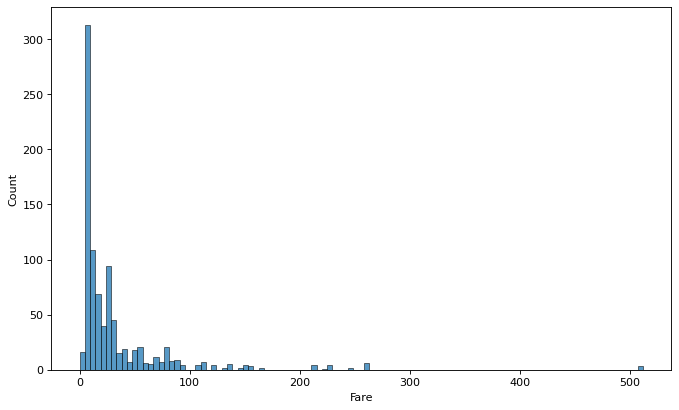

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt 

def hist(data,x,log=False):
  plt.figure(figsize = (10,6),dpi=80) 
  return sns.histplot(data=df, x=x, log_scale=log)

hist(df,'Fare')

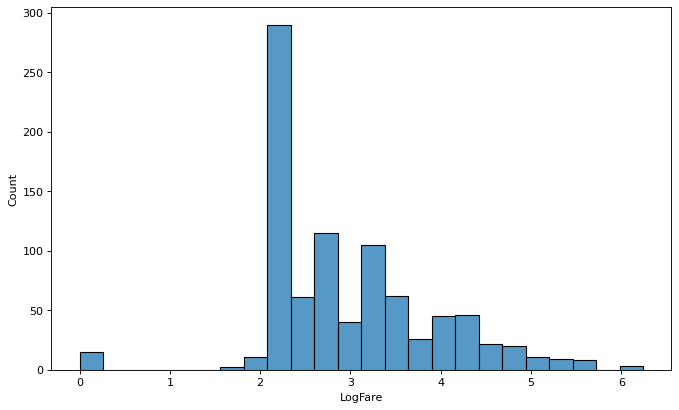

In [10]:
df['LogFare'] = np.log(df['Fare']+1)

hist(df,'LogFare')

Also we can get a quick summary about the categorical data in our dataset:

In [11]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Clearly, we can't multiply strings like `male` or any other by numerical coefficients, we have to replace those by numbers, to do that, with pandas we can create _dummy variables_, we will do this for certain categories of interest:


In [12]:
df = pd.get_dummies(df, columns = ['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [13]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


With this we can create our dependent and independent variable, they both need to be pytoroch tensors: 

In [14]:
from torch import tensor

In [15]:
t_dep = tensor(df.Survived)

indep_cols = indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [16]:
t_indep.shape

torch.Size([891, 12])

## setting up a linear model

Para empezar el modelo lineal debemos iniciallizar (en este caso aleaotriamente) nuestros coeficeintes del modelo en la variable `coeffs`

In [17]:
torch.manual_seed(420)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5

In [18]:
t_indep*coeffs

tensor([[ 6.7178, -0.3010,  0.0000, -0.8381, -0.1525, -0.0000,  0.0000,  0.0000, -0.2494, -0.0000, -0.0000, -0.0965],
        [11.6035, -0.3010,  0.0000, -1.7002, -0.0000, -0.3446,  0.3856,  0.0000, -0.0000, -0.3867, -0.0000, -0.0000],
        [ 7.9392, -0.0000,  0.0000, -0.8694, -0.0000, -0.3446,  0.0000,  0.0000, -0.2494, -0.0000, -0.0000, -0.0965],
        [10.6874, -0.3010,  0.0000, -1.5851, -0.0000, -0.3446,  0.3856,  0.0000, -0.0000, -0.0000, -0.0000, -0.0965],
        [10.6874, -0.0000,  0.0000, -0.8749, -0.1525, -0.0000,  0.0000,  0.0000, -0.2494, -0.0000, -0.0000, -0.0965],
        [ 7.3285, -0.0000,  0.0000, -0.8924, -0.1525, -0.0000,  0.0000,  0.0000, -0.2494, -0.0000, -0.2895, -0.0000],
        [16.4891, -0.0000,  0.0000, -1.5759, -0.1525, -0.0000,  0.3856,  0.0000, -0.0000, -0.0000, -0.0000, -0.0965],
        ...,
        [ 7.6339, -0.0000,  0.0000, -0.8284, -0.1525, -0.0000,  0.0000,  0.0000, -0.2494, -0.0000, -0.0000, -0.0965],
        [11.9088, -0.0000,  2.3793, -1.3525

In [19]:
vals, indices = t_indep.max(dim=0)
t_indep = t_indep / vals

para calcular el resultado de nuestras predcciones utilizaremos el broadcasting de python para hacer la multiplicacion de vector por matrix (la matriz de variables independientes por el vector de coeficientes) las cuales sumadas me daran la predccion de acuerdo con los coeficientes 

$
m = ax_1 + bx_2 + cx_3 + ... + \alpha x_n
$

In [20]:
t_indep*coeffs

tensor([[ 0.0840, -0.0376,  0.0000, -0.1343, -0.1525, -0.0000,  0.0000,  0.0000, -0.2494, -0.0000, -0.0000, -0.0965],
        [ 0.1450, -0.0376,  0.0000, -0.2724, -0.0000, -0.3446,  0.3856,  0.0000, -0.0000, -0.3867, -0.0000, -0.0000],
        [ 0.0992, -0.0000,  0.0000, -0.1393, -0.0000, -0.3446,  0.0000,  0.0000, -0.2494, -0.0000, -0.0000, -0.0965],
        [ 0.1336, -0.0376,  0.0000, -0.2540, -0.0000, -0.3446,  0.3856,  0.0000, -0.0000, -0.0000, -0.0000, -0.0965],
        [ 0.1336, -0.0000,  0.0000, -0.1402, -0.1525, -0.0000,  0.0000,  0.0000, -0.2494, -0.0000, -0.0000, -0.0965],
        [ 0.0916, -0.0000,  0.0000, -0.1430, -0.1525, -0.0000,  0.0000,  0.0000, -0.2494, -0.0000, -0.2895, -0.0000],
        [ 0.2061, -0.0000,  0.0000, -0.2525, -0.1525, -0.0000,  0.3856,  0.0000, -0.0000, -0.0000, -0.0000, -0.0965],
        ...,
        [ 0.0954, -0.0000,  0.0000, -0.1327, -0.1525, -0.0000,  0.0000,  0.0000, -0.2494, -0.0000, -0.0000, -0.0965],
        [ 0.1489, -0.0000,  0.3965, -0.2167

In [21]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:10]

tensor([-0.5863, -0.5107, -0.7305, -0.2134, -0.5050, -0.7428,  0.0902, -0.7212, -0.5876, -0.7466])

this is just a starting point for our coefficients, now let's do the gradient descent

In [22]:
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.8567)

In [23]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs,deps,indeps): return torch.abs(calc_preds(coeffs, indeps) - deps).mean() 

## Doing a gradient descent 

Para realizar el gradiente descendiente, primero debemos 'decirle' a pytorch que en un futuro querremos calcualr este con respecto a los coeficientes:

In [24]:
coeffs.requires_grad_()

tensor([ 0.3054, -0.3010,  0.4759, -0.3972, -0.1525, -0.3446,  0.3856,  0.1876, -0.2494, -0.3867, -0.2895, -0.0965], requires_grad=True)

Notemos como ahora la funcion `loss` cambio al momento de nosotros invocar la funcion `requires_grad` sobre los coeficientes:

In [25]:
loss = calc_loss(coeffs, t_dep, t_indep)
loss

tensor(0.8567, grad_fn=<MeanBackward0>)

Y para calcular los gradientes invocamos la funcion `backward()`

In [26]:
loss.backward()

In [27]:
coeffs.grad

tensor([-0.2994, -0.0637, -0.0595, -0.4266, -0.5398, -0.3524, -0.1549, -0.1863, -0.5511, -0.1886, -0.0864, -0.6173])

In [28]:
with torch.no_grad():
  coeffs.sub_(coeffs.grad*0.1)
  coeffs.grad.zero_()
  print(calc_loss(coeffs, t_dep, t_indep))

tensor(0.7207)


As we can see, after applying the gradient descent one time, the loss of the model heave decreased considerably:

## Training the linear model

Before the training of the model, we have to create two separately detasets for the calculation of the metrics, the validation and the training set, we can do this using the method `RandomSplitter` by fast.ai, in it we have to specify a seed, and the dataset (in this case, the dataset `train.csv`):

In [29]:
df

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,4.280593,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,B96 B98,2.639057,0,1,0,1,0,0,0,1
887,888,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,3.433987,1,0,1,0,0,0,0,1
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",24.0,1,2,W./C. 6607,23.4500,B96 B98,3.196630,1,0,0,0,1,0,0,1
889,890,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,3.433987,0,1,1,0,0,1,0,0


In [30]:
from fastai.data.transforms import RandomSplitter

trn_split, val_split = RandomSplitter(seed = 42)(df)

Note that this method returns us the indices of the original dataset that will be used in the training and validation sets. Because of this, we have to apply those indices to both the dependent variables and the independent variables:

In [31]:
trn_split

(#713) [788,525,821,253,374,98,215,313,281,305...]

In [32]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]

Now, we can create functions for the following tasks, updating coefficients, doing one full gradient descent step,and initialising coeffs to random numbers   

In [33]:
def update_coeffs(coeffs,lr):
  coeffs.sub_(coeffs.grad * lr)
  coeffs.grad.zero_()  

In [34]:
def one_epoch(coeffs,lr):
  loss = calc_loss(coeffs, trn_dep, trn_indep)
  loss.backward()
  with torch.no_grad(): update_coeffs(coeffs, lr)
  print(f'{loss:.3f}', end='; ')

In [35]:
def init_coeffs():
  return (torch.rand(n_coeff) - 0.5).requires_grad_()

We can use this functions to train our model:

In [36]:
def train_model(epochs=30, lr=0.01):
  torch.manual_seed(42)
  coeffs = init_coeffs()
  for i in range(epochs): one_epoch(coeffs, lr=lr)
  return coeffs

In [37]:
coeffs = train_model(18, lr=0.2)

0.603; 0.533; 0.473; 0.426; 0.385; 0.364; 0.351; 0.333; 0.323; 0.319; 0.304; 0.310; 0.294; 0.299; 0.290; 0.298; 0.286; 0.298; 

let's take a look for the coefficients for each column

In [38]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(0.3236),
 'SibSp': tensor(0.3410),
 'Parch': tensor(-0.1211),
 'LogFare': tensor(0.5121),
 'Sex_male': tensor(-0.3934),
 'Sex_female': tensor(0.4033),
 'Pclass_1': tensor(0.1240),
 'Pclass_2': tensor(0.2347),
 'Pclass_3': tensor(0.1507),
 'Embarked_C': tensor(-0.0218),
 'Embarked_Q': tensor(0.2214),
 'Embarked_S': tensor(-0.0197)}

In [39]:
preds = calc_preds(coeffs, val_indep)

In [40]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [41]:
results.float().mean()

tensor(0.7865)

In [42]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

In [43]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [44]:
coeffs = train_model(epochs=40,lr=50)

0.546; 0.288; 0.214; 0.212; 0.210; 0.209; 0.208; 0.207; 0.206; 0.205; 0.204; 0.203; 0.203; 0.202; 0.202; 0.201; 0.201; 0.201; 0.200; 0.200; 0.200; 0.200; 0.199; 0.199; 0.199; 0.199; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 

In [45]:
acc(coeffs)

tensor(0.8258)

## using matrix product

In [46]:
val_indep@coeffs

tensor([ 10.1158,  -8.7656,  -9.8172,  -7.1378,  -7.3456,  -7.5210,   2.3744,   4.8210, -14.8739,   2.1261, -14.0905, -10.0958, -14.2120,
          3.4232, -14.1209,  -7.6275,  -7.7650,   4.7176,  -7.3792,  -1.8886, -14.0357,  -7.7031,   8.6173,   4.3012, -14.0178,  -8.8214,
         -2.0041,  -7.7444, -13.9797,   3.4218,   4.5163,  -2.7898, -14.0013, -14.0788,  10.0746,  -2.5745,  -7.6183,   9.0196, -14.0341,
         -2.0118,  -7.3231, -14.0341,  -7.7355,   8.9737, -14.0066,  -2.7542, -13.8714, -14.2217,  -8.7746,  -1.8419,  -2.5481, -14.9289,
        -14.8095, -14.0522,  -7.3712,  -7.4125,  -8.7655, -14.2157, -14.0135, -14.0043,  -3.2942, -14.1538,  -7.8570, -14.0148,   4.6170,
         -7.5494,  -7.3387, -14.0397,  -9.1585,   4.7074, -14.0495,   2.0614,  -7.4056, -14.0199,  -7.4852, -13.9820, -14.0341,  -7.6219,
         -7.3043,  -7.4842,  -7.5804,   8.4794, -14.0289, -14.0429,   4.6509,  -3.5437,  -3.2404,   4.3841,   8.9456,  -7.3318, -14.0859,
        -14.0341,   9.0188,  -9.85

In [47]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [48]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [49]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [51]:
coeffs = train_model(lr=100)
acc(coeffs)

0.516; 0.322; 0.286; 0.203; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

tensor(0.8258)

## A neural network

In [52]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [53]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [54]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [55]:
coeffs = train_model(lr=1.4)

0.550; 0.543; 0.537; 0.529; 0.519; 0.506; 0.491; 0.472; 0.448; 0.419; 0.388; 0.358; 0.334; 0.316; 0.300; 0.287; 0.275; 0.265; 0.257; 0.251; 0.246; 0.241; 0.238; 0.235; 0.232; 0.230; 0.228; 0.226; 0.225; 0.223; 

In [56]:
coeffs = train_model(lr=20)

0.550; 0.460; 0.327; 0.302; 0.326; 0.220; 0.201; 0.200; 0.203; 0.200; 0.197; 0.194; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 

In [57]:
acc(coeffs)

tensor(0.8258)

## Deep learning

In [63]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [64]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [65]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [67]:
coeffs = train_model(lr=16)

0.548; 0.454; 0.419; 0.404; 0.397; 0.393; 0.390; 0.388; 0.387; 0.386; 0.385; 0.385; 0.384; 0.384; 0.383; 0.383; 0.383; 0.382; 0.382; 0.382; 0.382; 0.382; 0.382; 0.381; 0.381; 0.381; 0.381; 0.381; 0.381; 0.381; 

In [68]:
acc(coeffs)

tensor(0.5955)